In [72]:
# !pip install numpy
# !pip install matplotlib 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

$$\Huge \text{Geomterical Properties of the Slope}$$

The slope is divided into 11 slices


$del\_x - \Delta x$


$h - \text{Total height of each slice at the midpoint of their base}$


$h1 - \text{Component of height in top soil layer}$


$h2 - \text{Component of height in base soil layer}$


In [32]:
# del_x
del_x = np.array([10.667, 14.725, 10, 10, 10, 10, 10, 10, 10, 10, 19.839])
np.sum(del_x)

np.float64(125.231)

In [33]:
# h
h =  np.array([14.289, 32.853, 41.21, 42.206, 41.385, 39.044, 35.33, 30.339, 24.044, 16.385, 7.01])

In [34]:
# Weight calculations
h1 = np.array([14.289, 32.853, 37.500, 32.500, 27.500, 22.500, 17.500, 12.500, 7.500, 2.5, 0.0])
h2 = np.array([0.0, 0.0, 3.767, 9.707, 13.885, 16.544, 17.839, 17.839, 16.544, 13.885, 7.011])

# Unit weights of soil 1 and soil 2 in pcf
gamma_1 = 125
gamma_2 = 110

# Weight of the slice
W = ((h1 * gamma_1) + (h2 * gamma_2)) * del_x
np.sum(W)

np.float64(415833.68369000003)

In [35]:
# Piezometric head, hp
hp = np.array([0, 8.638, 18.114, 22.83, 25.76, 27.17, 26.59, 24.09, 20.29, 15.14, 7.11])

In [36]:
# alpha
alpha = np.array([63, 48, 35, 27, 19, 9, 3, -3, -10, -17, -30])

$$\Huge \text{Ordinary Method of Slices}$$

\begin{equation}
F = \frac{\text{Resisting Moment}}{\text{Driving Moment}}
\end{equation}

\begin{equation}
F = \frac{\sum{(C'\Delta l + (Wcos\alpha - u\Delta l)tan\phi ')}}{\sum{Wsin\alpha}}
\end{equation}

In [37]:
# Driving Moment = W * sin(alpha)
W_sina = W * np.sin(np.radians(alpha))
np.sum(W_sina)

np.float64(120388.41387679074)

In [38]:
# W * cos(alpha)
W_cosa = W * np.cos(np.radians(alpha)) 
np.sum(W_cosa)

np.float64(363951.7473487243)

In [39]:
# del_l
del_l = del_x / np.cos(np.radians(alpha))

In [40]:
# pore water pressure, u

#unit weight of water in pcf
gamma_w = 62.43

# 'u' in each slice
u = gamma_w * hp

In [41]:
# U = u * del_l * cos(alpha)^^2
U = u * del_l * np.cos(np.radians(alpha)) * np.cos(np.radians(alpha))

In [42]:
# Friction angle, phi'
phi = np.array([25, 25, 30, 30, 30, 30, 30, 30, 30, 30, 30])

In [43]:
# N' tan(phi') = ((W * cos(alpha)) - (u * del_l * cos(alpha)^^2)) * tan(phi')
N_tan_phi = (W_cosa - U) * np.tan(np.radians(phi))

In [44]:
# c' considered at the base of the each slice
c = np.array([600, 600, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
# c' * del_l
c_del_l = c * del_l

In [46]:
# Factor of Safety
f_oms = (np.sum(c_del_l)+np.sum(N_tan_phi))/np.sum(W_sina)
np.sum(c_del_l)+np.sum(N_tan_phi)

np.float64(163300.00766443723)

$$\textcolor{red}{\text{Factor of safety from OMS is 1.356}}$$


___


___

$$\Huge \text{Bishop's Simplified Method}$$


\begin{equation}
F = \frac{\sum{\frac{(C'\Delta x + (W - u\Delta x)tan\phi ')}{m_\alpha}}}{\sum{Wsin\alpha}}
\end{equation}

where,
\begin{equation}
m_\alpha = cos\alpha + \frac{sin\alpha.tan\phi}{F}
\end{equation}

The initial guess for $F$ is taken from the OMS and iterated until the difference between $F_{i+1}$ and $F_i$ is less than a tolerance value. For this problem, it is set to be 1e-3.

In [47]:
# c' * del_x
c_del_x = c * del_x

In [48]:
# u * del_x
u_del_x = u * del_x

In [49]:
# N' = W - (u * del_x)
N = W - u_del_x

In [50]:
# N'_tan_phi_2 = N * tan(phi') (to differentiate N_tan_phi from OMS)
N_tan_phi_2 = N * np.tan(np.radians(phi))

In [51]:
# Numerator for Resisting Moment
resisting_moment_num = c_del_x + N_tan_phi_2

In [52]:
def compute_m_alpha(alpha: np.ndarray, phi: np.ndarray, f_trial: float) -> np.ndarray:
    """
    Computes the m_alpha factor used in Bishop's Simplified Method.

    Args:
        alpha (np.ndarray): 1D array of inclination angles in degrees.
        phi (np.ndarray): 1D array of internal friction angles in degrees.
        f_trial (float): Trial factor of safety.

    Returns:
        np.ndarray: Computed m_alpha values for each slice.
    """
    return np.cos(np.radians(alpha)) + (np.sin(np.radians(alpha)) * np.tan(np.radians(phi))) / f_trial


In [53]:
def compute_f(alpha: np.ndarray, 
              phi: np.ndarray, 
              resisting_moment_num: np.ndarray, 
              W_sina: np.ndarray, 
              f_initial: float, 
              tol: float = 1e-3, 
              max_iter: int = 100) -> float:
    """
    Computes the factor of safety (F) using Bishop's Simplified Procedure.

    Args:
        alpha (np.ndarray): 1D array of inclination angles in degrees.
        phi (np.ndarray): 1D array of internal friction angles in degrees.
        resisting_moment_num (np.ndarray): 1D array of numerator values for the resisting moment calculation.
        W_sina (np.ndarray): 1D array of driving moment.
        f_initial (float): Initial trial factor of safety.
        tol (float, optional): Convergence tolerance. Defaults to 1e-3.
        max_iter (int, optional): Maximum number of iterations to avoid infinite loops. Defaults to 100.

    Returns:
        float: Computed factor of safety (F).
    """
    f_trial = f_initial
    for _ in range(max_iter):
        m_alpha = compute_m_alpha(alpha, phi, f_trial)
        resisting_moment_2 = resisting_moment_num / m_alpha
        f_res = np.sum(resisting_moment_2) / np.sum(W_sina)

        # Check for convergence
        if abs(f_res - f_trial) < tol:
            return f_res

        f_trial = f_res  # Update F trial
    

In [54]:
# Define parameters
f_trial_initial = f_oms   # Assume initial trial for 'F' from OMS
tolerance = 1e-3
max_iteration = 100

In [55]:
# Compute F
f_final = compute_f(alpha, phi, resisting_moment_num, W_sina, f_trial_initial, tolerance, max_iteration)

$$\textcolor{red}{\text{Factor of safety from Bishop's Simplified Method is 1.508}}$$

---
---

$$\Huge \text{Calculation of Normal Stresses}$$

### For Ordinary Method of Slices:

#### Total Stress
$$
\begin{flalign}
\sigma = \frac{W \cos\alpha}{\Delta l} &&
\end{flalign}
$$

#### Effective Stress
$$
\begin{flalign}
\sigma' = \sigma - u \cos^2\alpha &&
\end{flalign}
$$

$$
\begin{flalign}
\sigma' = \frac{W \cos\alpha}{\Delta l} - u \cos^2\alpha &&
\end{flalign}
$$

### For Bishop's Simplified Method:

#### Total Stress
$$
\begin{flalign}
N = \frac{W-\frac{1}{F}(c'\Delta l-u\Delta l \tan \phi ')\sin \alpha}{m_{\alpha}} &&
\end{flalign}
$$

$$
\begin{flalign}
\sigma = \frac{N}{\Delta l} &&&
\end{flalign}
$$


#### Effective Stress
$$
\begin{flalign}
\sigma' = \sigma - u &&
\end{flalign}
$$

In [59]:
# Total and Effective Stress from OMS
total_stress_oms = W_cosa / del_l
effective_stress_oms = total_stress_oms - (U / del_l)

In [81]:
# Total and Effective Stress from Bishop's Simplified Method
m_alpha = compute_m_alpha(alpha, phi, f_final)
N_bishop = (W - ((c_del_l - (u * del_l * np.tan(np.radians(phi))) * np.sin(np.radians(alpha))) / f_final)) / m_alpha

total_stress_bishop = N_bishop / del_l
effective_stress_bishop = total_stress_bishop - u

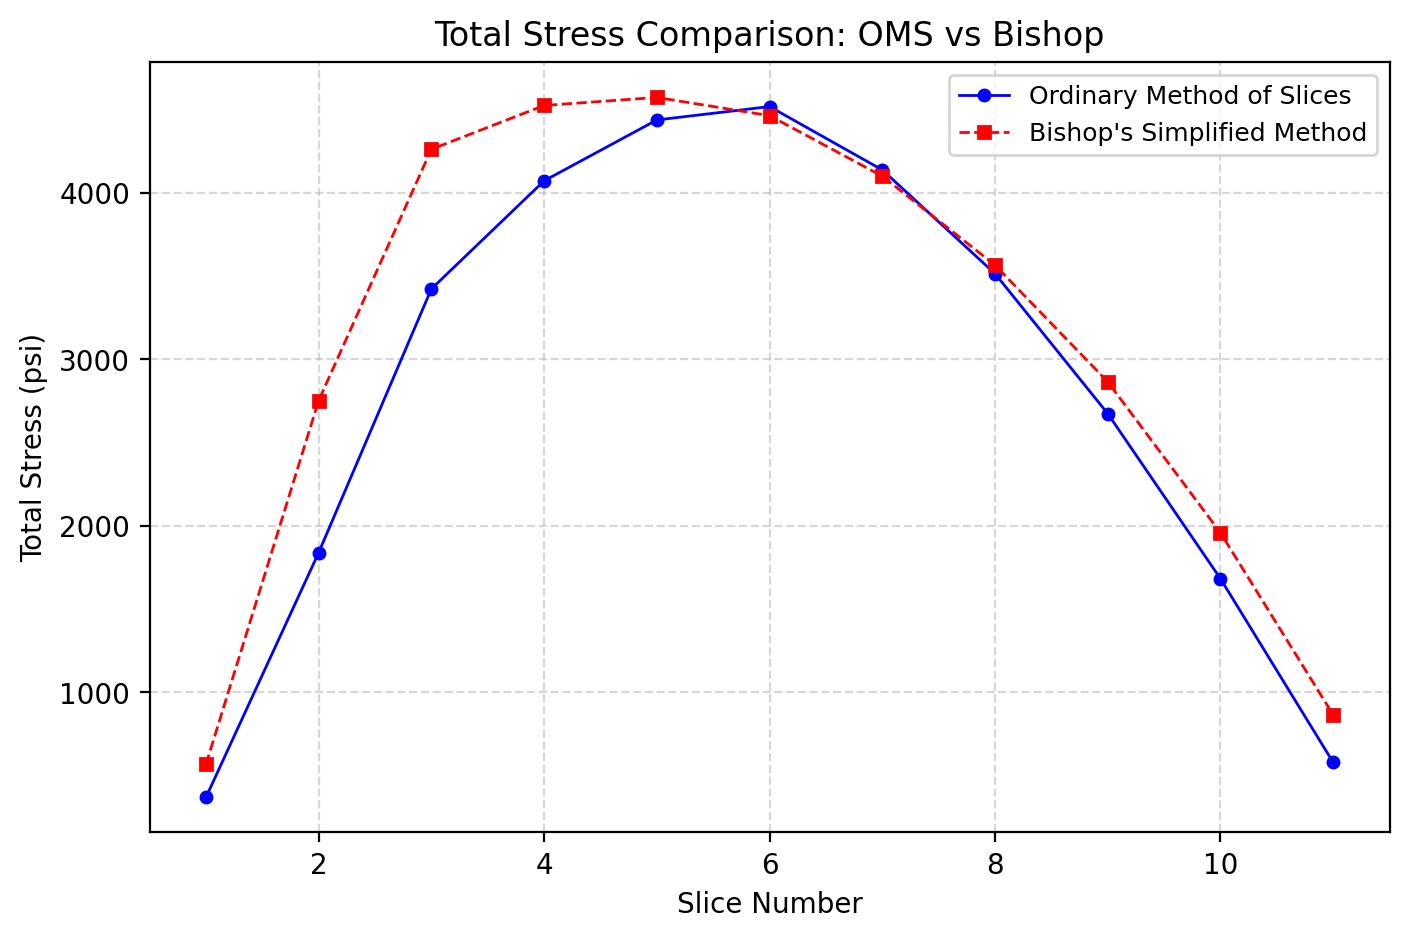

In [82]:
# Total Stress Comparison 

num_slices = len(total_stress_bishop)
x_slices = np.arange(1, num_slices + 1)  # Slice numbers (starting from 1)

# Create the plot with better settings
plt.figure(figsize=(8, 5), dpi=100)  # Adjust size and resolution

# Plot OMS Total Stress
plt.plot(x_slices, total_stress_oms, marker='o', markersize=4, linestyle='-', linewidth=1, 
         label="Ordinary Method of Slices", color='blue')

# Plot Bishop's Total Stress
plt.plot(x_slices, total_stress_bishop, marker='s', markersize=4, linestyle='--', linewidth=1, 
         label="Bishop's Simplified Method", color='red')

# Labels and Title with reduced font sizes
plt.xlabel("Slice Number", fontsize=10)
plt.ylabel("Total Stress (psi)", fontsize=10)
plt.title("Total Stress Comparison: OMS vs Bishop", fontsize=12)

# Grid, Legend, and Display with adjusted font sizes
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)
plt.show()

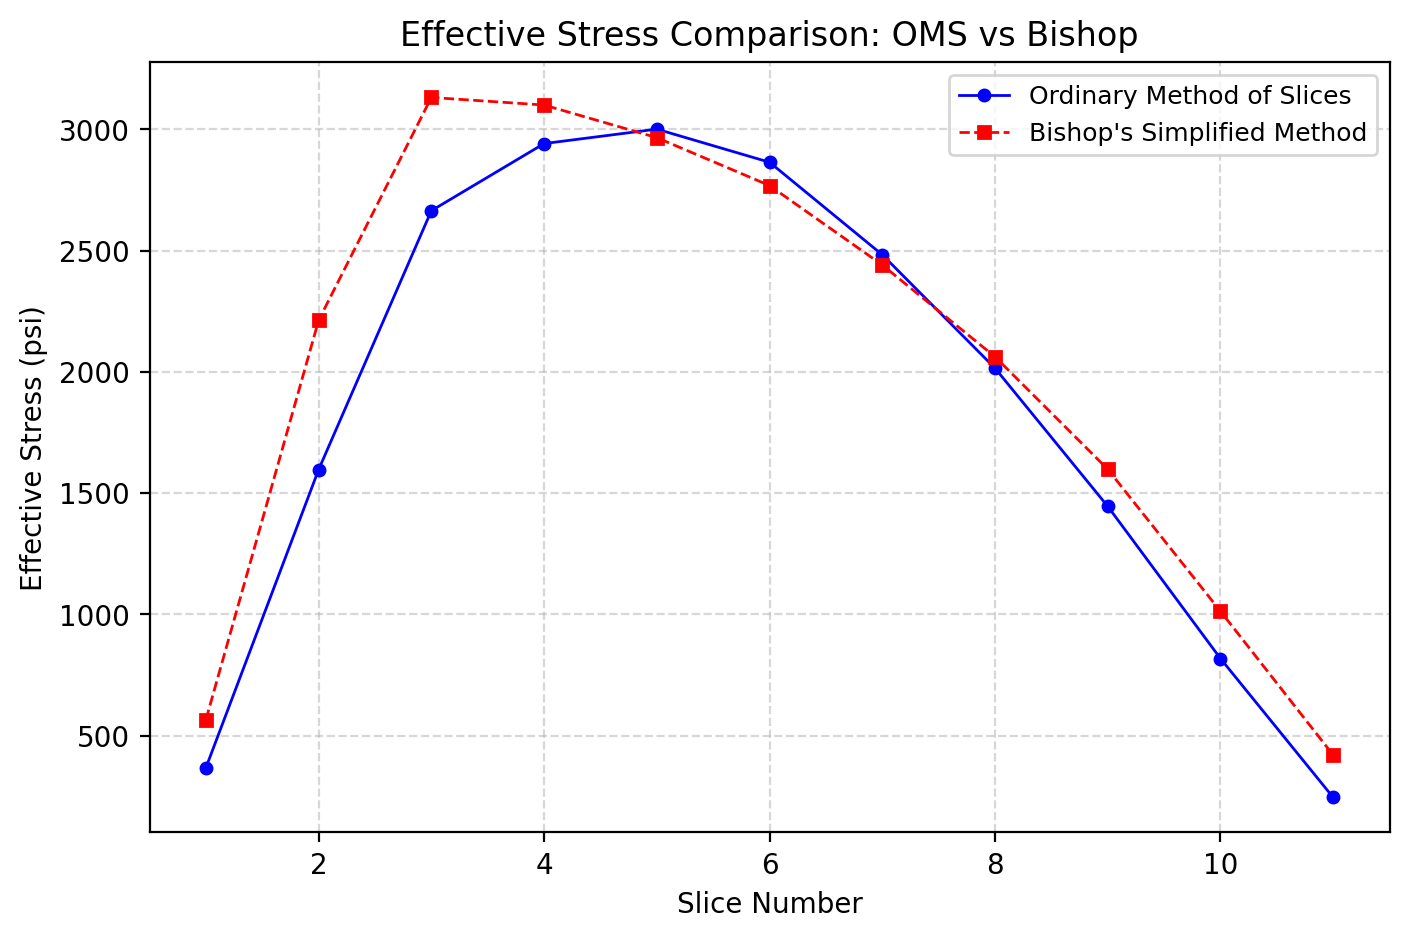

In [83]:
# Effective Stress Comparison 

num_slices = len(total_stress_bishop)
x_slices = np.arange(1, num_slices + 1)  # Slice numbers (starting from 1)

# Create the plot with better settings
plt.figure(figsize=(8, 5), dpi=100)  # Adjust size and resolution

# Plot OMS Total Stress
plt.plot(x_slices, effective_stress_oms, marker='o', markersize=4, linestyle='-', linewidth=1, 
         label="Ordinary Method of Slices", color='blue')

# Plot Bishop's Total Stress
plt.plot(x_slices, effective_stress_bishop, marker='s', markersize=4, linestyle='--', linewidth=1, 
         label="Bishop's Simplified Method", color='red')

# Labels and Title with reduced font sizes
plt.xlabel("Slice Number", fontsize=10)
plt.ylabel("Effective Stress (psi)", fontsize=10)
plt.title("Effective Stress Comparison: OMS vs Bishop", fontsize=12)

# Grid, Legend, and Display with adjusted font sizes
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=9)
plt.show()